### Toys

In [1]:
import ast
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict, Counter
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
from tqdm import tqdm

In [2]:
dataset_name = "Toys"
dataset_dir = "/data/common/RecommendationDatasets/{dataset_name}_Amazon14/topics/".format(dataset_name=dataset_name)

topics = [
    "age", 
    "assembly", 
    "battery", 
    "durability", 
    "educational", 
    "engagement", 
    "functionality", 
    "materials", 
    "price", 
    "safety"
]

sentiments = [
    "positive",
    "negative",
    "neutral"
]

topics.sort()
print(topics)
with open(os.path.join(dataset_dir, "topics.json"), "w") as f:
    json.dump(topics, f)

['age', 'assembly', 'battery', 'durability', 'educational', 'engagement', 'functionality', 'materials', 'price', 'safety']


In [3]:
data_df = pd.read_csv(os.path.join(dataset_dir, "statement.csv"))
data_df.head()

,helpful,reviewTime,rating,timestamp,review,user_name,user_id,item_id,review_title,statements
0,"[0, 0]","01 29, 2014",5.0,1390953600,I like the item pricing. My granddaughter want...,Angie,A1VXOAVRGKGEAK,0439893577,Magnetic board,"[{'statement': 'comes with affordable price', ..."
1,"[1, 1]","03 28, 2014",4.0,1395964800,Love the magnet easel... great for moving to d...,Candace,A8R62G708TSCM,0439893577,it works pretty good for moving to different a...,"[{'statement': 'has a magnetic easel', 'topic'..."
2,"[1, 1]","01 28, 2013",5.0,1359331200,Both sides are magnetic. A real plus when you...,capemaychristy,A21KH420DK0ICA,0439893577,love this!,"[{'statement': 'has magnetic sides', 'topic': ..."
3,"[0, 0]","02 8, 2014",5.0,1391817600,Bought one a few years ago for my daughter and...,dcrm,AR29QK6HPFYZ4,0439893577,Daughters love it,"[{'statement': 'my daughter loves it', 'topic'..."
4,"[1, 1]","05 5, 2014",4.0,1399248000,I have a stainless steel refrigerator therefor...,DoyZ,ACCH8EOML6FN5,0439893577,Great to have so he can play with his alphabet...,[{'statement': 'has limited space for magnets'...


In [4]:
statement_triplets = data_df["statements"].tolist()
print(statement_triplets[0:5])

["[{'statement': 'comes with affordable price', 'topic': 'price', 'sentiment': 'positive'}, {'statement': 'has a surface suitable for writing', 'topic': 'materials', 'sentiment': 'neutral'}]", "[{'statement': 'has a magnetic easel', 'topic': 'functionality', 'sentiment': 'positive'}, {'statement': 'is portable', 'topic': 'assembly', 'sentiment': 'positive'}, {'statement': 'requires a non-skid pad on the bottom', 'topic': 'safety', 'sentiment': 'negative'}]", "[{'statement': 'has magnetic sides', 'topic': 'materials', 'sentiment': 'positive'}, {'statement': 'suitable for multiple children', 'topic': 'age', 'sentiment': 'positive'}, {'statement': 'four-year-old can find letters for words', 'topic': 'educational', 'sentiment': 'positive'}, {'statement': 'two-year-old can find pictures the words spell', 'topic': 'educational', 'sentiment': 'positive'}, {'statement': 'grandkids liked it a lot', 'topic': 'engagement', 'sentiment': 'positive'}]", "[{'statement': 'my daughter loves it', 'topic

In [5]:
i = 0
for triplet_list in statement_triplets:
    triplet_list = ast.literal_eval(triplet_list)
    for triplet in triplet_list:
        statement = triplet.get("statement").lower().strip()
        topic = triplet.get("topic").lower().strip()
        sentiment = triplet.get("sentiment").lower().strip()

        print(statement.center(60), topic.center(20), sentiment.center(10), sep="|\t\t\t")
        i += 1

    if i > 40:
        break

                comes with affordable price                 |			       price        |			 positive 
             has a surface suitable for writing             |			     materials      |			 neutral  
                    has a magnetic easel                    |			   functionality    |			 positive 
                        is portable                         |			      assembly      |			 positive 
           requires a non-skid pad on the bottom            |			       safety       |			 negative 
                     has magnetic sides                     |			     materials      |			 positive 
               suitable for multiple children               |			        age         |			 positive 
          four-year-old can find letters for words          |			    educational     |			 positive 
       two-year-old can find pictures the words spell       |			    educational     |			 positive 
                  grandkids liked it a lot                  |			     engagement     |			 positive 
          

In [6]:
def process_triplets(statement_triplets, topics, sentiments):
    correct_triplets = {}
    wrong_topics = {}
    wrong_sentiments = {}
    wrong_topics_and_sentiments = {}
    
    for triplet_list in statement_triplets:
        if not triplet_list: continue
        if type(triplet_list) != list:
            try:
                triplet_list = ast.literal_eval(triplet_list)
            except:
                continue
    
        for triplet in triplet_list:
            if not triplet: continue

            accepted_topic = True
            accepted_sentiment = True
                
            topic = triplet.get("topic")
            if topic: topic = topic.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            if topic not in topics: accepted_topic = False

            sentiment = triplet.get("sentiment")
            if sentiment: sentiment = sentiment.lower().strip()
            else: continue
            if sentiment not in sentiments: accepted_sentiment = False
        
            statement = triplet.get("statement")
            if statement: statement = statement.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            
            if not (accepted_topic or accepted_sentiment):
                if topic not in wrong_topics_and_sentiments:
                    wrong_topics_and_sentiments[topic] = {}
                if sentiment not in wrong_topics_and_sentiments[topic]:
                    wrong_topics_and_sentiments[topic][sentiment] = {}
                if statement not in wrong_topics_and_sentiments[topic][sentiment]:
                    wrong_topics_and_sentiments[topic][sentiment][statement] = 0
                wrong_topics_and_sentiments[topic][sentiment][statement] += 1

            elif accepted_sentiment and not accepted_topic:
                if topic not in wrong_topics:
                    wrong_topics[topic] = {}
                if sentiment not in wrong_topics[topic]:
                    wrong_topics[topic][sentiment] = {}
                if statement not in wrong_topics[topic][sentiment]:
                    wrong_topics[topic][sentiment][statement] = 0
                wrong_topics[topic][sentiment][statement] += 1

            elif accepted_topic and not accepted_sentiment:
                if topic not in wrong_sentiments:
                    wrong_sentiments[topic] = {}
                if sentiment not in wrong_sentiments[topic]:
                    wrong_sentiments[topic][sentiment] = {}
                if statement not in wrong_sentiments[topic][sentiment]:
                    wrong_sentiments[topic][sentiment][statement] = 0
                wrong_sentiments[topic][sentiment][statement] += 1      

            else:
                if topic not in correct_triplets:
                    correct_triplets[topic] = {}
                if sentiment not in correct_triplets[topic]:
                    correct_triplets[topic][sentiment] = {}
                if statement not in correct_triplets[topic][sentiment]:
                    correct_triplets[topic][sentiment][statement] = 0
                correct_triplets[topic][sentiment][statement] += 1    
                
    return correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments

In [7]:
correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments = process_triplets(
    statement_triplets, topics, sentiments
)

In [8]:
len(correct_triplets), len(wrong_topics), len(wrong_sentiments), len(wrong_topics_and_sentiments)

(10, 172, 2, 0)

In [9]:
def build_topic_stats_df(topics):
    all_topics = sorted(topics.keys())
    all_sentiments = sorted({s for t in topics.values() for s in t.keys()})
    rows = []
    for topic in all_topics:
        row = {}
        uniq_total = 0
        freq_total = 0
        for s in all_sentiments:
            counts = topics[topic].get(s, {})
            u = len(counts)
            f = int(sum(counts.values())) if counts else 0
            row[(s, "unique")] = u
            row[(s, "total")] = f
            uniq_total += u
            freq_total += f
        row[("TOTAL", "unique")] = uniq_total
        row[("TOTAL", "total")] = freq_total
        rows.append(row)
    cols = []
    for s in all_sentiments:
        cols.append((s, "unique"))
        cols.append((s, "total"))
    cols.extend([("TOTAL", "unique"), ("TOTAL", "total")])
    df = pd.DataFrame(rows, index=all_topics, columns=pd.MultiIndex.from_tuples(cols))
    df = df.fillna(0).astype(int)
    return df

In [10]:
correct_triplets_df_stats = build_topic_stats_df(correct_triplets)
print(correct_triplets_df_stats)

              negative        neutral        positive           TOTAL        
                unique  total  unique  total   unique   total  unique   total
age              12658  14861   12886  15771    34236   64279   59780   94911
assembly         19568  22250   19062  21934    27075   39551   65705   83735
battery           2159   3007    2397   3861     2312    3632    6868   10500
durability       18311  22304    3003   3419    21122   44704   42436   70427
educational       4176   4519    5583   5821    45373   55789   55132   66129
engagement       13356  15869    5371   5718    91548  137038  110275  158625
functionality    34750  37280   24333  25292    83109   98061  142192  160633
materials        12203  13489   27025  30507    41006   59654   80234  103650
price             8958  12918    4816   5444    16225   30697   29999   49059
safety            9383  10397    1562   1723     7785    9239   18730   21359


In [11]:
correct_triplets_df_stats.sum(axis=0)

negative  unique    135522
          total     156894
neutral   unique    106038
          total     119490
positive  unique    369791
          total     542644
TOTAL     unique    611351
          total     819028
dtype: int64

In [12]:
wrong_sentiments

{'price': {'cautious': {'not recommended for kids who have never seen the show': 1}},
 'safety': {'hopeful': {'are removable': 1}}}

In [13]:
wrong_topics_df_stats = build_topic_stats_df(wrong_topics)
print(wrong_topics_df_stats)

                 negative       neutral       positive        TOTAL      
                   unique total  unique total   unique total unique total
accessories             0     0      22    22       52    52     74    74
accuracy                4     4       1     1        1     1      6     6
aesthetics             17    17       5     5       38    51     60    73
appearance             43    43      34    34      162   180    239   257
articulation            3     3       1     1       34    35     38    39
...                   ...   ...     ...   ...      ...   ...    ...   ...
warranty                0     0       1     1        0     0      1     1
water resistance        2     2       0     0        8     8     10    10
waterproof              0     0       0     0        1     1      1     1
weather                 3     3       3     3        0     0      6     6
weight                  2     2       5    10       12    13     19    25

[172 rows x 8 columns]


In [14]:
wrong_topics_df_stats.sum(axis=0)

negative  unique    1036
          total     1320
neutral   unique    1953
          total     2597
positive  unique    2522
          total     3253
TOTAL     unique    5511
          total     7170
dtype: int64

In [15]:
(wrong_topics_df_stats.sum(axis=0) / (wrong_topics_df_stats.sum(axis=0) + correct_triplets_df_stats.sum(axis=0))) * 100

negative  unique    0.758652
          total     0.834313
neutral   unique    1.808484
          total     2.127172
positive  unique    0.677387
          total     0.595900
TOTAL     unique    0.893393
          total     0.867831
dtype: float64

In [16]:
wrong_topics_stats = wrong_topics_df_stats["TOTAL"]["unique"].to_dict()
print(wrong_topics_stats)

{'accessories': 74, 'accuracy': 6, 'aesthetics': 60, 'appearance': 239, 'articulation': 38, 'artwork': 3, 'authenticity': 2, "author's expertise": 2, 'availability': 758, 'background': 1, 'balance': 4, 'brand': 134, 'brand reputation': 14, 'branding': 3, 'capacity': 8, 'character': 5, 'characteristics': 1, 'characters': 2, 'cleaning': 6, 'cleanliness': 1, 'color': 9, 'comfort': 1, 'company': 18, 'company reputation': 2, 'comparison': 48, 'compatibility': 96, 'complexity': 4, 'components': 11, 'concealability': 1, 'concept': 2, 'condition': 3, 'contents': 19, 'convenience': 2, 'customer service': 39, 'delivery': 8, 'depth': 1, 'design': 242, 'desire': 2, 'difficulty': 122, 'dislikes': 1, 'disposal': 1, 'distinctiveness': 1, 'duration': 39, 'emotional': 1, 'emotional attachment': 2, 'emotional impact': 6, 'emotional response': 1, 'emotional value': 1, 'entertainment': 1, 'evaluation': 5, 'exclusivity': 1, 'execution': 1, 'expectation': 2, 'experience': 3, 'fairness': 5, 'features': 2, 'f

In [17]:
# try to assign correct topic if possible
for topic in wrong_topics:
    print(topic)
    for sent in wrong_topics[topic]:
        statements = wrong_topics[topic][sent]
        statements = list(dict(sorted(statements.items(), key=lambda x: x[1])))
        if len(statements) > 4:
            statements = statements[:4]
        print("\t", sent, ":", "\n\t\t".join(statements))

portability
	 positive : is great to travel with
		can be toted for play
		is excellent to bring anywhere
		is small enough to pack on trips
	 neutral : can be brought to most places
		has been taken on trips
		can be taken on a 6 hour flight
		toy is portable due to light weight
	 negative : not great for taking with you
size
	 positive : is nice and large
		is small enough to fit in the glove box
		is a good size (12 14 inches)
		is transportable
	 negative : can easily be lost
		wish they had a larger size
		are a bit too big for saboteur
		too small
	 neutral : miniature is 1&#34; long x 1&#34; wide x 2&#34; tall
		is about 2 inches long and 1.25 inches wide
		is at scale with other miniatures
		is on the large side
theme
	 negative : theme is visually underrepresented
		has almost zero theme without flavor text
		has a theme that may deter some players
		ascension has a unclear theme
	 neutral : has a d&d theme
		theme rests on flavor text
		players control different animal phyla


**Prompt** : ```The extraction of triplets (atomic statement, topic, sentiment) from reviews produced topics that are not in the accepted topics list (represented by their short name). I will give you the list of incorrect topics, with a few example statements per sentiment. Analyze the statements and estimate the closest accepted topic it can be assigned to. If no statement is provided, do not assign anything; and if an assignment is impossible, do not assign one either. Here are the examples [EXAMPLES]. Here is the list of accepted topics for the Amazon Toys dataset:
ACCEPTED TOPICS (short name (long name): description) [TOPICS]
You must output a JSON object; keys are the incorrect topics and their values are the short name of the accepted topic they’re assigned to. Use None for incorrect topics that are not assigned.```

In [18]:
gpt_assignation = {
    "portability": "assembly",
    "size": "assembly",
    "theme": "engagement",
    "difficulty": "age",
    "duration": "engagement",
    "gameplay": "engagement",
    "fairness": "engagement",
    "religion": None,
    "emotional attachment": None,
    "availability": None,
    "storyline": "engagement",
    "social": "engagement",
    "unknown": None,
    "story": "engagement",
    "company": None,
    "recommendation": None,
    "purchase": None,
    "quality": "durability",
    "popularity": None,
    "none": None,
    "components": "assembly",
    "name": None,
    "brand": None,
    "visibility": "safety",
    "history": None,
    "idea": None,
    "customer service": None,
    "overall": None,
    "design": "materials",
    "maintenance": "materials",
    "usage": "engagement",
    "health": None,
    "appearance": "materials",
    "aesthetics": "materials",
    "plan": None,
    "space": "assembly",
    "value": "price",
    "quantity": "assembly",
    "power": "battery",
    "speed": "functionality",
    "compatibility": "functionality",
    "sentiment": None,
    "general": None,
    "cleanliness": "materials",
    "cleaning": "materials",
    "comparison": None,
    "stability": "durability",
    "practicality": "engagement",
    "accessories": "assembly",
    "expectation": "functionality",
    "accuracy": "materials",
    "personality": None,
    "color": "materials",
    "size and completeness": "assembly",
    "water resistance": "durability",
    "makeup": "materials",
    "outfit": "materials",
    "range": "functionality",
    "uniqueness": None,
    "temperature": "safety",
    "style": "materials",
    "physical appearance": "materials",
    "author's expertise": None,
    "shipping": None,
    "weight": "assembly",
    "brand reputation": None,
    "sound": "functionality",
    "contents": "assembly",
    "emotional impact": None,
    "comfort": "materials",
    "volume": "functionality",
    "weather": None,
    "seller": None,
    "geographic coverage": None,
    "nostalgia": None,
    "size and weight": "assembly",
    "overall quality": "durability",
    "timeliness": None,
    "marketing": None,
    "quality control": "durability",
    "capacity": "assembly",
    "depth": "assembly",
    "initial impression": None,
    "reputation": None,
    "play value": "engagement",
    "packaging": "assembly",
    "surprise": None,
    "replayability": "engagement",
    "noise": "functionality",
    "company reputation": None,
    "product quality": "durability",
    "experience": None,
    "storage": "assembly",
    "posability": "functionality",
    "complexity": "age",
    "authenticity": None,
    "fit": "assembly",
    "support": None,
    "background": None,
    "waterproof": "durability",
    "character": None,
    "instructions": "assembly",
    "personal opinion": None,
    "rules": "engagement",
    "gift": None,
    "product": None,
    "purchase history": None,
    "emotional response": None,
    "philanthropy": None,
    "concept": None,
    "grip": "materials",
    "social impact": None,
    "noise level": "functionality",
    "personal": None,
    "disposal": None,
    "evaluation": None,
    "service": None,
    "luck": "engagement",
    "shade": None,
    "features": "functionality",
    "sustainability": None,
    "reusability": None,
    "release": None,
    "replacement": None,
    "execution": None,
    "performance": "functionality",
    "price and value": "price",
    "entertainment": "engagement",
    "review": None,
    "flexibility": "functionality",
    "variety": "engagement",
    "time": "engagement",
    "manufacturing": None,
    "delivery": None,
    "concealability": "assembly",
    "reliability": "durability",
    "distinctiveness": None,
    "artwork": "materials",
    "visual appeal": "materials",
    "preference": None,
    "presentation": "materials",
    "product line": None,
    "loss prevention": None,
    "shape": "materials",
    "release date": None,
    "rarity": None,
    "convenience": None,
    "warranty": None,
    "desire": None,
    "tablet": "functionality",
    "emotional value": None,
    "branding": None,
    "historical significance": None,
    "topic": None,
    "scale": "assembly",
    "furniture": None,
    "characteristics": None,
    "emotional": None,
    "poseability": "functionality",
    "dislikes": None,
    "skill": "age",
    "reviews": None,
    "balance": "engagement",
    "characters": "engagement",
    "articulation": "functionality",
    "user experience": "engagement",
    "condition": "assembly",
    "return policy": None,
    "inclusion": "assembly"
}

In [19]:
claude_assignation = {
  "portability": "assembly",
  "size": "assembly",
  "theme": "engagement",
  "difficulty": "age",
  "duration": "engagement",
  "gameplay": "engagement",
  "fairness": "engagement",
  "religion": None,
  "emotional attachment": "engagement",
  "availability": "price",
  "storyline": "engagement",
  "social": "engagement",
  "unknown": None,
  "story": "engagement",
  "company": "price",
  "recommendation": None,
  "purchase": "price",
  "quality": "durability",
  "popularity": "engagement",
  "none": None,
  "components": "assembly",
  "name": None,
  "brand": "price",
  "visibility": "functionality",
  "history": None,
  "idea": None,
  "customer service": "price",
  "overall": None,
  "design": "materials",
  "maintenance": "durability",
  "usage": "engagement",
  "health": "safety",
  "appearance": "materials",
  "aesthetics": "materials",
  "plan": None,
  "space": "assembly",
  "value": "price",
  "quantity": "assembly",
  "power": "functionality",
  "speed": "functionality",
  "compatibility": "functionality",
  "sentiment": None,
  "general": None,
  "cleanliness": "materials",
  "cleaning": "durability",
  "comparison": None,
  "stability": "durability",
  "practicality": "functionality",
  "accessories": "assembly",
  "expectation": None,
  "accuracy": "materials",
  "personality": "engagement",
  "color": "materials",
  "size and completeness": "assembly",
  "water resistance": "durability",
  "makeup": "materials",
  "outfit": "materials",
  "range": "functionality",
  "uniqueness": "materials",
  "temperature": "functionality",
  "style": "materials",
  "physical appearance": "materials",
  "author's expertise": None,
  "shipping": "price",
  "weight": "assembly",
  "brand reputation": "price",
  "sound": "functionality",
  "contents": "assembly",
  "emotional impact": "engagement",
  "comfort": "functionality",
  "volume": "functionality",
  "weather": None,
  "seller": "price",
  "geographic coverage": "assembly",
  "nostalgia": "engagement",
  "size and weight": "assembly",
  "overall quality": "durability",
  "timeliness": "price",
  "marketing": None,
  "quality control": "durability",
  "capacity": "assembly",
  "depth": "assembly",
  "initial impression": None,
  "reputation": "price",
  "play value": "engagement",
  "packaging": "assembly",
  "surprise": "engagement",
  "replayability": "engagement",
  "noise": "functionality",
  "company reputation": "price",
  "product quality": "durability",
  "experience": None,
  "storage": "assembly",
  "posability": "functionality",
  "complexity": "age",
  "authenticity": "materials",
  "fit": "assembly",
  "support": "functionality",
  "background": None,
  "waterproof": "durability",
  "character": "engagement",
  "instructions": "assembly",
  "personal opinion": None,
  "rules": "age",
  "gift": "engagement",
  "product": None,
  "purchase history": None,
  "emotional response": "engagement",
  "philanthropy": None,
  "concept": "engagement",
  "grip": "functionality",
  "social impact": "engagement",
  "noise level": "functionality",
  "personal": None,
  "disposal": "materials",
  "evaluation": None,
  "service": "price",
  "luck": "engagement",
  "shade": "functionality",
  "features": "functionality",
  "sustainability": "materials",
  "reusability": "materials",
  "release": None,
  "replacement": None,
  "execution": None,
  "performance": "functionality",
  "price and value": "price",
  "entertainment": "engagement",
  "review": None,
  "flexibility": "functionality",
  "variety": "assembly",
  "time": "engagement",
  "manufacturing": "materials",
  "delivery": "price",
  "concealability": "functionality",
  "reliability": "durability",
  "distinctiveness": "materials",
  "artwork": "materials",
  "visual appeal": "materials",
  "preference": None,
  "presentation": "materials",
  "product line": None,
  "loss prevention": "functionality",
  "shape": "assembly",
  "release date": None,
  "rarity": "price",
  "convenience": "functionality",
  "warranty": "price",
  "desire": "engagement",
  "tablet": None,
  "emotional value": "engagement",
  "branding": "price",
  "historical significance": None,
  "exclusivity": "price",
  "fun": "engagement",
  "wait time": "price",
  "topic": None,
  "scale": "assembly",
  "furniture": "materials",
  "characteristics": "materials",
  "emotional": "engagement",
  "poseability": "functionality",
  "dislikes": None,
  "skill": "age",
  "reviews": None,
  "balance": "functionality",
  "characters": "engagement",
  "articulation": "functionality",
  "user experience": "engagement",
  "condition": "durability",
  "return policy": "price",
  "inclusion": "assembly"
}

In [20]:
gemini_assignation = {
  "portability": "assembly",
  "size": "assembly",
  "theme": "engagement",
  "difficulty": "age",
  "duration": "engagement",
  "gameplay": "engagement",
  "fairness": "engagement",
  "religion": None,
  "emotional attachment": "engagement",
  "availability": "price",
  "storyline": "engagement",
  "social": "engagement",
  "unknown": None,
  "story": "engagement",
  "company": "durability",
  "recommendation": "engagement",
  "purchase": "price",
  "quality": "durability",
  "popularity": "engagement",
  "none": None,
  "components": "durability",
  "name": "engagement",
  "brand": "durability",
  "visibility": "safety",
  "history": None,
  "idea": "engagement",
  "customer service": "durability",
  "overall": "durability",
  "design": "durability",
  "maintenance": "durability",
  "usage": "engagement",
  "health": "safety",
  "appearance": "engagement",
  "aesthetics": "engagement",
  "plan": None,
  "space": "assembly",
  "value": "price",
  "quantity": "assembly",
  "power": "battery",
  "speed": "functionality",
  "compatibility": "functionality",
  "sentiment": None,
  "general": "durability",
  "cleanliness": "durability",
  "cleaning": "durability",
  "comparison": "price",
  "stability": "durability",
  "practicality": "engagement",
  "accessories": "assembly",
  "expectation": "functionality",
  "accuracy": "educational",
  "personality": "engagement",
  "color": "assembly",
  "size and completeness": "assembly",
  "water resistance": "durability",
  "makeup": "appearance",
  "outfit": "appearance",
  "range": "functionality",
  "uniqueness": "engagement",
  "temperature": "safety",
  "style": "appearance",
  "physical appearance": "appearance",
  "author's expertise": None,
  "shipping": "price",
  "weight": "assembly",
  "brand reputation": "durability",
  "sound": "functionality",
  "contents": "assembly",
  "emotional impact": "engagement",
  "comfort": "safety",
  "volume": "functionality",
  "weather": "functionality",
  "seller": "price",
  "geographic coverage": "educational",
  "nostalgia": "engagement",
  "size and weight": "assembly",
  "overall quality": "durability",
  "timeliness": "price",
  "marketing": "engagement",
  "quality control": "durability",
  "capacity": "assembly",
  "depth": "assembly",
  "initial impression": "engagement",
  "reputation": "durability",
  "play value": "engagement",
  "packaging": "assembly",
  "surprise": "engagement",
  "replayability": "engagement",
  "noise": "functionality",
  "company reputation": "durability",
  "product quality": "durability",
  "experience": "durability",
  "storage": "assembly",
  "posability": "functionality",
  "complexity": "age",
  "authenticity": "durability",
  "fit": "assembly",
  "support": "durability",
  "background": None,
  "waterproof": "durability",
  "character": "engagement",
  "instructions": "assembly",
  "personal opinion": "engagement",
  "rules": "engagement",
  "gift": "price",
  "product": "durability",
  "purchase history": "price",
  "emotional response": "engagement",
  "philanthropy": "price",
  "concept": "engagement",
  "grip": "functionality",
  "social impact": "engagement",
  "noise level": "functionality",
  "personal": "engagement",
  "disposal": "safety",
  "evaluation": "durability",
  "service": "durability",
  "luck": "engagement",
  "shade": "functionality",
  "features": "functionality",
  "sustainability": "educational",
  "reusability": "durability",
  "release": "price",
  "replacement": "price",
  "execution": "durability",
  "performance": "functionality",
  "price and value": "price",
  "entertainment": "engagement",
  "review": "durability",
  "flexibility": "functionality",
  "variety": "engagement",
  "time": "engagement",
  "manufacturing": "durability",
  "delivery": "price",
  "concealability": "functionality",
  "reliability": "durability",
  "distinctiveness": "engagement",
  "artwork": "engagement",
  "visual appeal": "engagement",
  "preference": "engagement",
  "presentation": "engagement",
  "product line": "engagement",
  "loss prevention": "safety",
  "shape": "functionality",
  "release date": "price",
  "rarity": "price",
  "convenience": "engagement",
  "warranty": "durability",
  "desire": "engagement",
  "tablet": "functionality",
  "emotional value": "engagement",
  "branding": "durability",
  "historical significance": "educational",
  "exclusivity": "price",
  "fun": "engagement",
  "wait time": "price",
  "topic": None,
  "scale": "educational",
  "furniture": "appearance",
  "characteristics": "engagement",
  "emotional": "engagement",
  "poseability": "functionality",
  "dislikes": "durability",
  "skill": "age",
  "reviews": "durability",
  "balance": "engagement",
  "characters": "engagement",
  "articulation": "functionality",
  "user experience": "engagement",
  "condition": "durability",
  "return policy": "price",
  "inclusion": "assembly"
}

In [21]:
remain_wrong_topics = [t for t, n_st in wrong_topics_stats.items() if n_st >= 10]
print(remain_wrong_topics)
print(len(remain_wrong_topics))

['accessories', 'aesthetics', 'appearance', 'articulation', 'availability', 'brand', 'brand reputation', 'company', 'comparison', 'compatibility', 'components', 'contents', 'customer service', 'design', 'difficulty', 'duration', 'general', 'history', 'maintenance', 'marketing', 'name', 'noise', 'overall', 'packaging', 'play value', 'popularity', 'portability', 'purchase', 'quality', 'quantity', 'recommendation', 'shipping', 'size', 'story', 'storyline', 'theme', 'usage', 'value', 'water resistance', 'weight']
40


In [22]:
final_assignation = {}
for topic in wrong_topics:
    assignations = [
        gpt_assignation.get(topic, None),
        claude_assignation.get(topic, None),
        gemini_assignation.get(topic, None)
    ]
    value_set = set(assignations)
    for value in value_set:
        if value is None: continue
        if assignations.count(value) == 3:
            final_assignation[topic] = value

In [23]:
final_assignation

{'portability': 'assembly',
 'size': 'assembly',
 'theme': 'engagement',
 'difficulty': 'age',
 'duration': 'engagement',
 'gameplay': 'engagement',
 'fairness': 'engagement',
 'storyline': 'engagement',
 'social': 'engagement',
 'story': 'engagement',
 'quality': 'durability',
 'usage': 'engagement',
 'space': 'assembly',
 'value': 'price',
 'quantity': 'assembly',
 'speed': 'functionality',
 'compatibility': 'functionality',
 'stability': 'durability',
 'accessories': 'assembly',
 'size and completeness': 'assembly',
 'water resistance': 'durability',
 'range': 'functionality',
 'weight': 'assembly',
 'sound': 'functionality',
 'contents': 'assembly',
 'volume': 'functionality',
 'size and weight': 'assembly',
 'overall quality': 'durability',
 'quality control': 'durability',
 'capacity': 'assembly',
 'depth': 'assembly',
 'play value': 'engagement',
 'packaging': 'assembly',
 'replayability': 'engagement',
 'noise': 'functionality',
 'product quality': 'durability',
 'storage': 'as

In [24]:
extend_correct_triplets = correct_triplets.copy()
for wrong, correct in final_assignation.items():
    for sent in wrong_topics[wrong]:
        if sent not in extend_correct_triplets[correct]:
            extend_correct_triplets[correct][sent] = {}
        for statement in wrong_topics[wrong][sent]:
            if statement not in extend_correct_triplets[correct][sent]:
                extend_correct_triplets[correct][sent][statement] = 0
            extend_correct_triplets[correct][sent][statement] += wrong_topics[wrong][sent][statement]

In [25]:
extend_correct_triplets_df_stats = build_topic_stats_df(extend_correct_triplets)
print(extend_correct_triplets_df_stats)

              negative        neutral        positive           TOTAL        
                unique  total  unique  total   unique   total  unique   total
age              12710  14917   12914  15805    34274   64321   59898   95043
assembly         19889  22818   20240  23806    28136   41391   68265   88015
battery           2159   3007    2397   3861     2312    3632    6868   10500
durability       18338  22333    3005   3421    21170   44763   42513   70517
educational       4176   4519    5583   5821    45373   55789   55132   66129
engagement       13390  15905    5449   5801    91584  137087  110423  158793
functionality    34768  37308   24357  25319    83214   98186  142339  160813
materials        12203  13489   27025  30507    41006   59654   80234  103650
price             8968  12930    4818   5446    16253   30737   30039   49113
safety            9383  10397    1562   1723     7785    9239   18730   21359


In [26]:
extend_correct_triplets_df_stats.sum(axis=0)

negative  unique    135984
          total     157623
neutral   unique    107350
          total     121510
positive  unique    371107
          total     544799
TOTAL     unique    614441
          total     823932
dtype: int64

In [27]:
def process_dataset(data_df, topics, corrected_topics):
    corrected_topics_list = list(corrected_topics)

    all_triplets = {}
    cleaned_statements = []
    statement_idss = []
    topic_idss = []
    sentiment_idss = []
    sentiment_map = {"positive": +1, "neutral": 0, "negative": -1}
    
    for index, triplet_list in enumerate(data_df["statements"].tolist(), start=1):
        try:
            triplet_list = ast.literal_eval(triplet_list)
        except:
            cleaned_statements.append(None)
            statement_idss.append(None)
            topic_idss.append(None)
            sentiment_idss.append(None)
            continue

        new_triplet_list = []
        statement_ids = []
        topic_ids = []
        sentiment_ids = []
        
        for triplet in triplet_list:
            if not triplet: continue

            topic = triplet.get("topic")
            if topic: topic = topic.lower().replace("-", " ").replace("_", " ").strip()
            else: continue
            if topic not in (topics + corrected_topics_list): continue
            if topic in corrected_topics_list: topic = corrected_topics[topic]

            sentiment = triplet.get("sentiment")
            if sentiment: sentiment = sentiment.lower().strip()
            if sentiment not in sentiment_map: continue
                
            statement = triplet.get("statement")
            if statement: statement = statement.lower().replace("-", " ").replace("_", " ").strip()
            else: continue

            triplet_tuple = (statement, topic, sentiment)
            if triplet_tuple not in all_triplets:
                new_id = len(all_triplets)
                all_triplets[triplet_tuple] = {}
                all_triplets[triplet_tuple]["id"] = new_id
                all_triplets[triplet_tuple]["freq"] = 0
                
            all_triplets[triplet_tuple]["freq"] += 1

            topic_id = topics.index(topic)
            sentiment_id = sentiment_map[sentiment]
            statement_id = all_triplets[triplet_tuple]["id"]

            new_triplet = {"statement": statement, "topic": topic, "sentiment": sentiment}
            new_triplet_list.append(new_triplet)
            statement_ids.append(statement_id)
            topic_ids.append(topic_id)
            sentiment_ids.append(sentiment_id)

        if len(new_triplet_list) == 0:
            new_triplet_list = None
            statement_ids = None
            topic_ids = None
            sentiment_ids = None
            
        cleaned_statements.append(new_triplet_list)
        statement_idss.append(statement_ids)
        topic_idss.append(topic_ids)
        sentiment_idss.append(sentiment_ids)

        if index % 10_000 == 0:
            print("10000 samples processed...")

    print("Done!")
    n_none = cleaned_statements.count(None)
    print("Number of fails:", n_none)
    print("% of fails:", n_none/len(data_df))

    new_data_df = pd.DataFrame(data_df)
    new_data_df["statements"] = cleaned_statements
    new_data_df["statement_ids"] = statement_idss
    new_data_df["topic_ids"] = topic_idss
    new_data_df["sentiments"] = sentiment_idss
        
    columns = ["user_id", "item_id", "timestamp", "rating", "statements", "statement_ids", "topic_ids", "sentiments"]
    #new_data_df = new_data_df[columns]
    new_data_df = new_data_df.dropna(subset=columns)

    return new_data_df, all_triplets

In [28]:
new_data_df, all_triplets = process_dataset(data_df, topics, final_assignation)
print(new_data_df.head())

10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


10000 samples processed...


Done!
Number of fails: 3886
% of fails: 0.023186572552014655


  helpful   reviewTime  rating   timestamp  \
0  [0, 0]  01 29, 2014     5.0  1390953600   
1  [1, 1]  03 28, 2014     4.0  1395964800   
2  [1, 1]  01 28, 2013     5.0  1359331200   
3  [0, 0]   02 8, 2014     5.0  1391817600   
4  [1, 1]   05 5, 2014     4.0  1399248000   

                                              review       user_name  \
0  I like the item pricing. My granddaughter want...           Angie   
1  Love the magnet easel... great for moving to d...         Candace   
2  Both sides are magnetic.  A real plus when you...  capemaychristy   
3  Bought one a few years ago for my daughter and...            dcrm   
4  I have a stainless steel refrigerator therefor...            DoyZ   

          user_id     item_id  \
0  A1VXOAVRGKGEAK  0439893577   
1   A8R62G708TSCM  0439893577   
2  A21KH420DK0ICA  0439893577   
3   AR29QK6HPFYZ4  0439893577   
4   ACCH8EOML6FN5  0439893577   

                                        review_title  \
0                                  

In [29]:
statement_triplets = new_data_df["statements"].to_list()
len(statement_triplets)

163711

In [30]:
correct_triplets, wrong_topics, wrong_sentiments, wrong_topics_and_sentiments = process_triplets(
    statement_triplets, topics, sentiments
)

In [31]:
len(correct_triplets), len(wrong_topics), len(wrong_sentiments), len(wrong_topics_and_sentiments)

(10, 0, 0, 0)

In [32]:
final_correct_triplets_df_stats = build_topic_stats_df(correct_triplets)
print(final_correct_triplets_df_stats)

              negative        neutral        positive           TOTAL        
                unique  total  unique  total   unique   total  unique   total
age              12710  14917   12914  15805    34274   64321   59898   95043
assembly         19889  22818   20240  23806    28136   41391   68265   88015
battery           2159   3007    2397   3861     2312    3632    6868   10500
durability       18338  22333    3005   3421    21170   44763   42513   70517
educational       4176   4519    5583   5821    45373   55789   55132   66129
engagement       13390  15905    5449   5801    91584  137087  110423  158793
functionality    34768  37308   24357  25319    83214   98186  142339  160813
materials        12203  13489   27025  30507    41006   59654   80234  103650
price             8968  12930    4818   5446    16253   30737   30039   49113
safety            9383  10397    1562   1723     7785    9239   18730   21359


In [33]:
def plot_topic_sentiment_bars(
    df: pd.DataFrame,
    save_pdf_path: str | None = None,
    figsize=(11, 6.5)
):
    mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=[
        "#8da0cb", "#fc8d62", "#66c2a5", "#e78ac3", "#a6d854"
    ])
    mpl.rcParams['grid.linestyle'] = ":"
    mpl.rcParams['grid.linewidth'] = 0.6
    mpl.rcParams['grid.alpha'] = 0.7
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['legend.fontsize'] = 10
    mpl.rcParams['legend.frameon'] = False
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.right'] = False

    def get_col(df, sent, kind):
        if isinstance(df.columns, pd.MultiIndex):
            if (sent, kind) in df.columns:
                return df[(sent, kind)]
            for a, b in df.columns:
                if str(a).lower() == sent and str(b).lower() == kind:
                    return df[(a, b)]
        else:
            candidates = [
                f"{sent} {kind}",
                f"{sent}_{kind}",
                f"{sent}.{kind}",
                f"{sent.capitalize()} {kind}",
                f"{sent.capitalize()}_{kind}",
            ]
            for c in candidates:
                if c in df.columns:
                    return df[c]
            for c in df.columns:
                if sent in str(c).lower() and kind in str(c).lower():
                    return df[c]
        return pd.Series(0, index=df.index, dtype=float)

    def drop_total(df):
        if isinstance(df.columns, pd.MultiIndex):
            keep = [c for c in df.columns if str(c[0]).lower() != "total"]
            return df.loc[:, keep]
        else:
            keep = [c for c in df.columns if "total" != str(c).strip().lower()]
            return df[[c for c in df.columns if not str(c).lower().startswith("total ")]]

    df = drop_total(df).copy()
    df = df.sort_index(ascending=False)

    neg_u = get_col(df, "negative", "unique").astype(float)
    neg_t = get_col(df, "negative", "total").astype(float)
    neu_u = get_col(df, "neutral",  "unique").astype(float)
    neu_t = get_col(df, "neutral",  "total").astype(float)
    pos_u = get_col(df, "positive", "unique").astype(float)
    pos_t = get_col(df, "positive", "total").astype(float)

    fig, ax = plt.subplots(figsize=figsize)

    topics = df.index.to_list()
    y = np.arange(len(topics))

    group_height = 0.78
    n_series = 6
    bar_h = group_height / n_series

    NEG = "#d73027"
    NEU = "#377eb8"
    POS = "#1a9850"

    colors = {
        "neg_u": (NEG, 0.55),
        "neg_t": (NEG, 1.00),
        "neu_u": (NEU, 0.55),
        "neu_t": (NEU, 1.00),
        "pos_u": (POS, 0.55),
        "pos_t": (POS, 1.00),
    }

    series = [
        ("neg_u", neg_u, "Negative · Unique"),
        ("neg_t", neg_t, "Negative · Total"),
        ("neu_u", neu_u, "Neutral · Unique"),
        ("neu_t", neu_t, "Neutral · Total"),
        ("pos_u", pos_u, "Positive · Unique"),
        ("pos_t", pos_t, "Positive · Total"),
    ]

    start = y - group_height / 2 + 0.05
    for i, (key, values, label) in enumerate(series):
        c, a = colors[key]
        ax.barh(start + i * bar_h,
                values.values,
                height=bar_h * 0.92,
                label=label,
                color=c,
                alpha=a,
                edgecolor="none")

    ax.set_yticks(y)
    ax.set_yticklabels(topics)
    ax.set_xlabel("Count of statements")
    #ax.set_title("Topic × Sentiment")

    ax.grid(axis="x", which="both")
    ax.set_axisbelow(True)

    handles, labels = ax.get_legend_handles_labels()
    handles = handles[0::2] + handles[1::2]
    labels = labels[0::2] + labels[1::2]
    seen = set()
    h2, l2 = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l)
            h2.append(h)
            l2.append(l)
    ax.legend(h2, l2, ncols=2, loc="lower right", bbox_to_anchor=(1.0, 0.0), frameon=True)

    plt.tight_layout()

    if save_pdf_path:
        plt.savefig(save_pdf_path, dpi=300, bbox_inches="tight")
    plt.show()


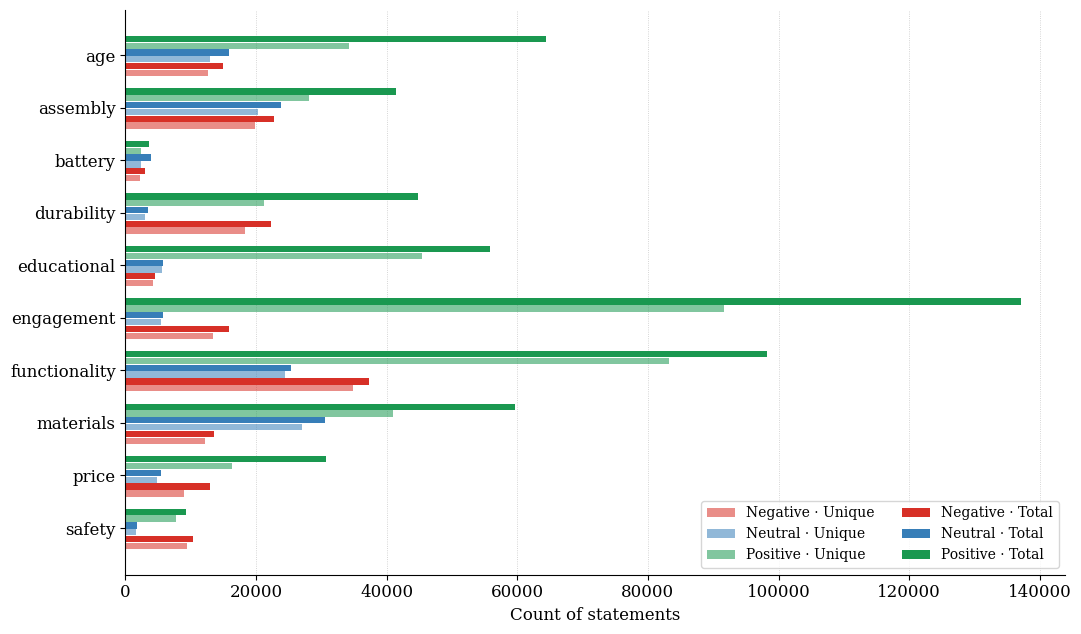

In [34]:
os.makedirs("plots", exist_ok=True)
plot_topic_sentiment_bars(
    final_correct_triplets_df_stats, 
    os.path.join("plots", dataset_name + "_topic_sentiment_statement_distribution.pdf")
)

In [35]:
new_data_df.to_csv(os.path.join(dataset_dir, "processed_dataset.csv"))

In [36]:
all_statements = []
all_topics = []
all_sentiments = []
all_freq = []

for i, ((statement, topic, sent), id_freq) in enumerate(all_triplets.items()):
    freq = id_freq["freq"]
    all_statements.append(statement)
    all_topics.append(topic)
    all_sentiments.append(sent)
    all_freq.append(freq)
    if i % 10_000 == 0:
        print((statement, topic, sent), freq)

statement_topic_sentiment_freq_df = pd.DataFrame({
    "statement": all_statements,
    "topic": all_topics,
    "sentiment": all_sentiments,
    "frequency": all_freq
})

print(len(statement_topic_sentiment_freq_df))

('comes with affordable price', 'price', 'positive') 1
('utilizes trivia cards and dvd based video and audio clips', 'functionality', 'neutral') 1
('makes a loud noise when pieces pop', 'safety', 'negative') 1
('allows for imaginative play and exploration', 'engagement', 'positive') 1
('plays classical music', 'engagement', 'positive') 3
('are not dented or cracked', 'durability', 'positive') 1
('will provide lots of entertainment', 'engagement', 'positive') 1
('encourages putting bolts into the base panel', 'educational', 'positive') 1
('requires assistance with paper cutter', 'functionality', 'negative') 1
('is a good doll for collecting', 'engagement', 'positive') 1
('may not be a long game', 'engagement', 'neutral') 1
('suction cups attach easily to most surfaces', 'assembly', 'positive') 1
('has potential to last through multiple children', 'durability', 'positive') 1
('helps improve hitting skills', 'educational', 'positive') 2
('requires safety goggles', 'safety', 'positive') 3


('game duration is short', 'engagement', 'neutral') 1
('requires manual removal of tiny plastic pieces from sheet', 'assembly', 'negative') 1
('my son was upset', 'age', 'neutral') 1
('compatible with various components', 'functionality', 'positive') 1
('is safe (not made of glass)', 'safety', 'positive') 1
('includes a table to eat snacks', 'assembly', 'positive') 1
("there's nothing to hold the room cards on the board", 'functionality', 'negative') 1
('guitar is attached to his body', 'assembly', 'negative') 1
('requires assistance from others to put balls back in', 'educational', 'neutral') 1
("can't stay still without screwing down, which can crack the plastic", 'safety', 'negative') 1
('may not react well to submersion in orange juice', 'durability', 'negative') 1
('factions are a lot of fun', 'engagement', 'positive') 1
('is added to a massive box of legos', 'materials', 'neutral') 1
('blades hit each other once launched', 'engagement', 'negative') 1
('is a better gift than candy

('has sheer black material with gold leopard print from waist down', 'materials', 'positive') 1
('stays on the bedroom floor', 'assembly', 'neutral') 1
('hair color fades back to blonde as it warms to room temperature', 'functionality', 'neutral') 1
('sets usually come with only one car', 'functionality', 'negative') 1
('has mechanical arms and battery pack', 'materials', 'neutral') 1
('has a lovely face', 'educational', 'positive') 1
('has elevator, crane, ramps, and nooks and crannies', 'functionality', 'positive') 1
('comes with wgp lightning', 'functionality', 'neutral') 1
('can be enjoyed even after finishing', 'engagement', 'positive') 1
('setup process takes over 45 minutes', 'assembly', 'negative') 1
('learns more english the more it is played with', 'educational', 'positive') 1
('fence that keeps the car inside the stadium gets hit a lot by the car', 'safety', 'negative') 1
('girls really like it', 'engagement', 'positive') 1
('may not be suitable for younger children due to a

614441


In [37]:
print(statement_topic_sentiment_freq_df.sample(n=10))

                                                statement          topic  \
81050              has appropriate levels for all players            age   
435620                        has virtual reality feature  functionality   
497848              reaction was basically a non reaction     engagement   
550894  jake the pirate can be raised to his secret lo...  functionality   
417416               is easy to handle for young children            age   
453927                            includes bags of bricks      materials   
276876               is a regular favorite among children     engagement   
109264                                    overpaid by $30          price   
90680                               can be taken in a car     engagement   
467447                 foam disks are used as projectiles      materials   

       sentiment  frequency  
81050   positive          1  
435620  positive          1  
497848  negative          1  
550894  positive          1  
417416  posit

In [38]:
statement_topic_sentiment_freq_df.to_csv(os.path.join(dataset_dir, "statement_topic_sentiment_freq.csv"))

In [39]:
def analyze_statements_dataset(df):
    print("=" * 80)
    print("STATEMENT DATASET STATISTICAL ANALYSIS")
    print("=" * 80)
    
    # General statistics
    print("\nGENERAL STATISTICS")
    print("-" * 40)
    n_users = df['user_id'].nunique()
    n_items = df['item_id'].nunique()
    n_interactions = len(df)
    
    print(f"Unique users: {n_users:,}")
    print(f"Unique items: {n_items:,}")
    print(f"Total interactions: {n_interactions:,}")
    
    # Expand statements for analysis
    expanded_data = []
    for idx, row in df.iterrows():
        user_id = row['user_id']
        item_id = row['item_id']
        statements = row['statements']
        
        if isinstance(statements, list):
            for stmt_dict in statements:
                if isinstance(stmt_dict, dict):
                    expanded_data.append({
                        'user_id': user_id,
                        'item_id': item_id,
                        'interaction_id': idx,
                        'statement': stmt_dict.get('statement', ''),
                        'topic': stmt_dict.get('topic', ''),
                        'sentiment': stmt_dict.get('sentiment', '')
                    })
    
    expanded_df = pd.DataFrame(expanded_data)
    
    if expanded_df.empty:
        print("No valid statements found in the dataset")
        return
    
    print(f"Total statements: {len(expanded_df):,}")
    print(f"Unique statements: {expanded_df['statement'].nunique():,}")
    
    # Get unique sentiments and topics
    sentiments = sorted(expanded_df['sentiment'].unique())
    topics = sorted(expanded_df['topic'].unique())
    
    print(f"Sentiments: {sentiments}")
    print(f"Topics ({len(topics)}): {topics}")
    
    # Function to calculate statistics
    def calculate_stats(data, group_by, count_by='statement', unique=True):
        if unique:
            # Count unique statements
            stats = data.groupby(group_by)[count_by].nunique()
        else:
            # Count with frequency (all statements)
            stats = data.groupby(group_by)[count_by].count()
        
        return {
            'average': stats.mean(),
            'maximum': stats.max(),
            'minimum': stats.min(),
            'median': stats.median(),
            'std': stats.std()
        }
    
    # 1. USER STATISTICS
    print("\n" + "=" * 80)
    print("USER STATISTICS")
    print("=" * 80)
    
    user_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'user_id', unique=unique)
        user_stats_results.append({
            'Metric': f'Statements per user ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'user_id', unique=unique)
                user_stats_results.append({
                    'Metric': f'Statements per user ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per user/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['user_id', 'topic'], unique=unique)
        user_stats_results.append({
            'Metric': f'Statements per user/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/user
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'user_id', unique=unique)
                user_stats_results.append({
                    'Metric': f'Statements per user for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    user_stats_df = pd.DataFrame(user_stats_results)
    print(user_stats_df.to_string(index=False))
    
    # 2. ITEM STATISTICS
    print("\n" + "=" * 80)
    print("ITEM STATISTICS")
    print("=" * 80)
    
    item_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'item_id', unique=unique)
        item_stats_results.append({
            'Metric': f'Statements per item ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'item_id', unique=unique)
                item_stats_results.append({
                    'Metric': f'Statements per item ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per item/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['item_id', 'topic'], unique=unique)
        item_stats_results.append({
            'Metric': f'Statements per item/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/item
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'item_id', unique=unique)
                item_stats_results.append({
                    'Metric': f'Statements per item for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    item_stats_df = pd.DataFrame(item_stats_results)
    print(item_stats_df.to_string(index=False))
    
    # 3. INTERACTION STATISTICS
    print("\n" + "=" * 80)
    print("INTERACTION STATISTICS")
    print("=" * 80)
    
    interaction_stats_results = []
    
    # Global (all sentiments)
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, 'interaction_id', unique=unique)
        interaction_stats_results.append({
            'Metric': f'Statements per interaction ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # By sentiment
    for sentiment in sentiments:
        sentiment_data = expanded_df[expanded_df['sentiment'] == sentiment]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not sentiment_data.empty:
                stats = calculate_stats(sentiment_data, 'interaction_id', unique=unique)
                interaction_stats_results.append({
                    'Metric': f'Statements per interaction ({label})',
                    'Sentiment': sentiment,
                    'Topic': 'All',
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    # Per interaction/topic
    for unique in [True, False]:
        label = "Unique" if unique else "With frequency"
        stats = calculate_stats(expanded_df, ['interaction_id', 'topic'], unique=unique)
        interaction_stats_results.append({
            'Metric': f'Statements per interaction/topic ({label})',
            'Sentiment': 'All',
            'Topic': 'All',
            'Average': f"{stats['average']:.2f}",
            'Maximum': f"{stats['maximum']:.0f}",
            'Minimum': f"{stats['minimum']:.0f}",
            'Median': f"{stats['median']:.2f}",
            'Std_Dev': f"{stats['std']:.2f}"
        })
    
    # Per topic/interaction
    for topic in topics:
        topic_data = expanded_df[expanded_df['topic'] == topic]
        for unique in [True, False]:
            label = "Unique" if unique else "With frequency"
            if not topic_data.empty:
                stats = calculate_stats(topic_data, 'interaction_id', unique=unique)
                interaction_stats_results.append({
                    'Metric': f'Statements per interaction for topic "{topic}" ({label})',
                    'Sentiment': 'All',
                    'Topic': topic,
                    'Average': f"{stats['average']:.2f}",
                    'Maximum': f"{stats['maximum']:.0f}",
                    'Minimum': f"{stats['minimum']:.0f}",
                    'Median': f"{stats['median']:.2f}",
                    'Std_Dev': f"{stats['std']:.2f}"
                })
    
    interaction_stats_df = pd.DataFrame(interaction_stats_results)
    print(interaction_stats_df.to_string(index=False))
    
    # 4. SENTIMENT AND TOPIC DISTRIBUTION
    print("\n" + "=" * 80)
    print("SENTIMENT AND TOPIC DISTRIBUTION")
    print("=" * 80)
    
    # Sentiment distribution
    sentiment_counts = expanded_df['sentiment'].value_counts()
    sentiment_unique_counts = expanded_df.groupby('sentiment')['statement'].nunique()
    
    sentiment_dist = pd.DataFrame({
        'Sentiment': sentiment_counts.index,
        'Total_Count': sentiment_counts.values,
        'Unique_Count': [sentiment_unique_counts.get(s, 0) for s in sentiment_counts.index],
        'Total_Percentage': (sentiment_counts.values / len(expanded_df) * 100),
        'Unique_Percentage': (sentiment_unique_counts.values / expanded_df['statement'].nunique() * 100)
    })
    
    print("Sentiment distribution:")
    print(sentiment_dist.round(2).to_string(index=False))
    
    # Topic distribution
    topic_counts = expanded_df['topic'].value_counts()
    topic_unique_counts = expanded_df.groupby('topic')['statement'].nunique()
    
    topic_dist = pd.DataFrame({
        'Topic': topic_counts.index,
        'Total_Count': topic_counts.values,
        'Unique_Count': [topic_unique_counts.get(t, 0) for t in topic_counts.index],
        'Total_Percentage': (topic_counts.values / len(expanded_df) * 100),
        'Unique_Percentage': (topic_unique_counts.values / expanded_df['statement'].nunique() * 100)
    })
    
    print("\nTopic distribution:")
    print(topic_dist.round(2).to_string(index=False))
    
    # 5. SENTIMENT x TOPIC CROSS-MATRIX
    print("\n" + "=" * 80)
    print("SENTIMENT x TOPIC CROSS-MATRIX")
    print("=" * 80)
    
    # With frequency
    cross_matrix_freq = pd.crosstab(expanded_df['sentiment'], expanded_df['topic'], margins=True)
    print("Matrix with frequency:")
    print(cross_matrix_freq)
    
    # Unique statements
    cross_matrix_unique = pd.crosstab(expanded_df['sentiment'], expanded_df['topic'], 
                                    values=expanded_df['statement'], aggfunc='nunique', margins=True)
    print("\nMatrix with unique statements:")
    print(cross_matrix_unique.fillna(0).astype(int))
    
    # 6. COMPREHENSIVE STATISTICS SUMMARY
    print("\n" + "=" * 80)
    print("COMPREHENSIVE STATISTICS SUMMARY")
    print("=" * 80)
    
    # Create a comprehensive summary DataFrame
    summary_stats = []
    
    # Helper function to add stats
    def add_stats(group_type, group_cols, sentiment_filter=None, topic_filter=None):
        data = expanded_df.copy()
        
        if sentiment_filter:
            data = data[data['sentiment'] == sentiment_filter]
        if topic_filter:
            data = data[data['topic'] == topic_filter]
        
        if data.empty:
            return
        
        for unique in [True, False]:
            count_type = "Unique" if unique else "Frequency"
            
            if unique:
                grouped = data.groupby(group_cols)['statement'].nunique()
            else:
                grouped = data.groupby(group_cols)['statement'].count()
            
            summary_stats.append({
                'Grouping': group_type,
                'Sentiment': sentiment_filter or 'All',
                'Topic': topic_filter or 'All',
                'Count_Type': count_type,
                'Average': round(grouped.mean(), 2),
                'Maximum': int(grouped.max()),
                'Minimum': int(grouped.min()),
                'Median': round(grouped.median(), 2),
                'Std_Dev': round(grouped.std(), 2)
            })
    
    # Add all combinations
    add_stats('Per user', ['user_id'])
    add_stats('Per user/topic', ['user_id', 'topic'])
    add_stats('Per item', ['item_id'])
    add_stats('Per item/topic', ['item_id', 'topic'])
    add_stats('Per interaction', ['interaction_id'])
    add_stats('Per interaction/topic', ['interaction_id', 'topic'])
    
    # By sentiment
    for sentiment in sentiments:
        add_stats('Per user', ['user_id'], sentiment_filter=sentiment)
        add_stats('Per item', ['item_id'], sentiment_filter=sentiment)
        add_stats('Per interaction', ['interaction_id'], sentiment_filter=sentiment)

    for topic in topics:
        add_stats('Per user', ['user_id'], topic_filter=topic)
        add_stats('Per item', ['item_id'], topic_filter=topic)
        add_stats('Per interaction', ['interaction_id'], topic_filter=topic)
    
    summary_df = pd.DataFrame(summary_stats)
    print("Comprehensive statistics summary:")
    print(summary_df.to_string(index=False))
    
    # 7. TOP CONTRIBUTORS
    print("\n" + "=" * 80)
    print("TOP CONTRIBUTORS")
    print("=" * 80)
    
    # Top users
    top_users_freq = expanded_df.groupby('user_id')['statement'].count().nlargest(5)
    top_users_unique = expanded_df.groupby('user_id')['statement'].nunique().nlargest(5)
    
    print("Top 5 users (by statement frequency):")
    for user_id, count in top_users_freq.items():
        print(f"  {user_id}: {count} statements")
    
    print("\nTop 5 users (by unique statements):")
    for user_id, count in top_users_unique.items():
        print(f"  {user_id}: {count} unique statements")
    
    # Top items
    top_items_freq = expanded_df.groupby('item_id')['statement'].count().nlargest(5)
    top_items_unique = expanded_df.groupby('item_id')['statement'].nunique().nlargest(5)
    
    print("\nTop 5 items (by statement frequency):")
    for item_id, count in top_items_freq.items():
        print(f"  {item_id}: {count} statements")
    
    print("\nTop 5 items (by unique statements):")
    for item_id, count in top_items_unique.items():
        print(f"  {item_id}: {count} unique statements")
    
    # 8. DIVERSITY STATISTICS
    print("\n" + "=" * 80)
    print("DIVERSITY STATISTICS")
    print("=" * 80)
    
    diversity_stats = []
    
    # Diversity per user (number of different topics)
    user_topic_diversity = expanded_df.groupby('user_id')['topic'].nunique()
    diversity_stats.append({
        'Metric': 'Topics per user',
        'Average': round(user_topic_diversity.mean(), 2),
        'Maximum': int(user_topic_diversity.max()),
        'Minimum': int(user_topic_diversity.min()),
        'Median': round(user_topic_diversity.median(), 2)
    })
    
    # Diversity per user (number of different sentiments)
    user_sentiment_diversity = expanded_df.groupby('user_id')['sentiment'].nunique()
    diversity_stats.append({
        'Metric': 'Sentiments per user',
        'Average': round(user_sentiment_diversity.mean(), 2),
        'Maximum': int(user_sentiment_diversity.max()),
        'Minimum': int(user_sentiment_diversity.min()),
        'Median': round(user_sentiment_diversity.median(), 2)
    })
    
    # Diversity per item
    item_topic_diversity = expanded_df.groupby('item_id')['topic'].nunique()
    diversity_stats.append({
        'Metric': 'Topics per item',
        'Average': round(item_topic_diversity.mean(), 2),
        'Maximum': int(item_topic_diversity.max()),
        'Minimum': int(item_topic_diversity.min()),
        'Median': round(item_topic_diversity.median(), 2)
    })
    
    item_sentiment_diversity = expanded_df.groupby('item_id')['sentiment'].nunique()
    diversity_stats.append({
        'Metric': 'Sentiments per item',
        'Average': round(item_sentiment_diversity.mean(), 2),
        'Maximum': int(item_sentiment_diversity.max()),
        'Minimum': int(item_sentiment_diversity.min()),
        'Median': round(item_sentiment_diversity.median(), 2)
    })
    
    diversity_df = pd.DataFrame(diversity_stats)
    print("Diversity statistics:")
    print(diversity_df.to_string(index=False))
    
    # 9. STATEMENT FREQUENCY ANALYSIS
    print("\n" + "=" * 80)
    print("STATEMENT FREQUENCY ANALYSIS")
    print("=" * 80)
    
    # Most frequent statements
    statement_freq = expanded_df['statement'].value_counts()
    print("Top 10 most frequent statements:")
    for i, (stmt, count) in enumerate(statement_freq.head(10).items(), 1):
        print(f"  {i:2d}. '{stmt[:50]}{'...' if len(stmt) > 50 else ''}' (count: {count})")
    
    # Statement length statistics
    expanded_df['statement_length'] = expanded_df['statement'].str.len()
    length_stats = expanded_df['statement_length'].describe()
    
    print(f"\nStatement length statistics:")
    print(f"  Average length: {length_stats['mean']:.1f} characters")
    print(f"  Maximum length: {length_stats['max']:.0f} characters")
    print(f"  Minimum length: {length_stats['min']:.0f} characters")
    print(f"  Median length: {length_stats['50%']:.1f} characters")
    
    print("\n" + "=" * 80)
    print("ANALYSIS COMPLETED")

In [40]:
analyze_statements_dataset(new_data_df)

STATEMENT DATASET STATISTICAL ANALYSIS

GENERAL STATISTICS
----------------------------------------
Unique users: 19,398
Unique items: 11,924
Total interactions: 163,711


Total statements: 823,932


Unique statements: 587,114
Sentiments: ['negative', 'neutral', 'positive']
Topics (10): ['age', 'assembly', 'battery', 'durability', 'educational', 'engagement', 'functionality', 'materials', 'price', 'safety']

USER STATISTICS


                                                        Metric Sentiment         Topic Average Maximum Minimum Median Std_Dev
                                  Statements per user (Unique)       All           All   41.76    2064       1  28.00   55.50
                          Statements per user (With frequency)       All           All   42.48    2264       1  29.00   57.26
                                  Statements per user (Unique)  negative           All    9.27     233       1   6.00   11.71
                          Statements per user (With frequency)  negative           All    9.32     239       1   6.00   11.79
                                  Statements per user (Unique)   neutral           All    7.11     322       1   4.00   12.70
                          Statements per user (With frequency)   neutral           All    7.15     332       1   4.00   12.89
                                  Statements per user (Unique)  positive           All   27.51    1838       1  19.00 

                                                        Metric Sentiment         Topic Average Maximum Minimum Median Std_Dev
                                  Statements per item (Unique)       All           All   67.49    1287       5  40.00   80.04
                          Statements per item (With frequency)       All           All   69.10    1390       5  40.00   84.38
                                  Statements per item (Unique)  negative           All   13.84     229       1   8.00   17.74
                          Statements per item (With frequency)  negative           All   13.93     241       1   8.00   18.03
                                  Statements per item (Unique)   neutral           All   10.53     194       1   6.00   13.90
                          Statements per item (With frequency)   neutral           All   10.63     200       1   6.00   14.15
                                  Statements per item (Unique)  positive           All   44.41     867       1  26.00 

                                                               Metric Sentiment         Topic Average Maximum Minimum Median Std_Dev
                                  Statements per interaction (Unique)       All           All    5.03      21       1   5.00    2.67
                          Statements per interaction (With frequency)       All           All    5.03      21       1   5.00    2.67
                                  Statements per interaction (Unique)  negative           All    2.22      15       1   2.00    1.47
                          Statements per interaction (With frequency)  negative           All    2.23      15       1   2.00    1.48
                                  Statements per interaction (Unique)   neutral           All    1.79      20       1   1.00    1.33
                          Statements per interaction (With frequency)   neutral           All    1.79      20       1   1.00    1.33
                                  Statements per interaction (Unique)

Sentiment distribution:
Sentiment  Total_Count  Unique_Count  Total_Percentage  Unique_Percentage
 positive       544799        358494             66.12              22.68
 negative       157623        133130             19.13              17.91
  neutral       121510        105154             14.75              61.06



Topic distribution:
        Topic  Total_Count  Unique_Count  Total_Percentage  Unique_Percentage
functionality       160813        140975             19.52               9.90
   engagement       158793        109884             19.27              11.40
    materials       103650         78510             12.58               1.13
          age        95043         58117             11.54               7.18
     assembly        88015         66957             10.68               9.35
   durability        70517         42135              8.56              18.72
  educational        66129         54869              8.03              24.01
        price        49113         29604              5.96              13.37
       safety        21359         18570              2.59               5.04
      battery        10500          6650              1.27               3.16

SENTIMENT x TOPIC CROSS-MATRIX


Matrix with frequency:
topic        age  assembly  battery  durability  educational  engagement  \
sentiment                                                                  
negative   14917     22818     3007       22333         4519       15905   
neutral    15805     23806     3861        3421         5821        5801   
positive   64321     41391     3632       44763        55789      137087   
All        95043     88015    10500       70517        66129      158793   

topic      functionality  materials  price  safety     All  
sentiment                                                   
negative           37308      13489  12930   10397  157623  
neutral            25319      30507   5446    1723  121510  
positive           98186      59654  30737    9239  544799  
All               160813     103650  49113   21359  823932  



Matrix with unique statements:
topic        age  assembly  battery  durability  educational  engagement  \
sentiment                                                                  
negative   12710     19889     2159       18338         4176       13390   
neutral    12914     20240     2397        3005         5583        5449   
positive   34274     28136     2312       21170        45373       91584   
All        58117     66957     6650       42135        54869      109884   

topic      functionality  materials  price  safety     All  
sentiment                                                   
negative           34768      12203   8968    9383  133130  
neutral            24357      27025   4818    1562  105154  
positive           83214      41006  16253    7785  358494  
All               140975      78510  29604   18570  587114  

COMPREHENSIVE STATISTICS SUMMARY


Comprehensive statistics summary:
             Grouping Sentiment         Topic Count_Type  Average  Maximum  Minimum  Median  Std_Dev
             Per user       All           All     Unique    41.76     2064        1    28.0    55.50
             Per user       All           All  Frequency    42.48     2264        1    29.0    57.26
       Per user/topic       All           All     Unique     5.53      665        1     3.0     8.83
       Per user/topic       All           All  Frequency     5.61      704        1     3.0     9.04
             Per item       All           All     Unique    67.49     1287        5    40.0    80.04
             Per item       All           All  Frequency    69.10     1390        5    40.0    84.38
       Per item/topic       All           All     Unique     8.46      404        1     5.0    13.14
       Per item/topic       All           All  Frequency     8.63      466        1     5.0    13.70
      Per interaction       All           All     Unique 

Top 5 users (by statement frequency):
  AJGU56YG8G1DQ: 2264 statements
  A2WW57XX2UVLM6: 1237 statements
  A1II2ZRPKZAQQD: 1115 statements
  A2KLFJ0GHM3NFO: 1011 statements
  A1POFVVXUZR3IQ: 948 statements

Top 5 users (by unique statements):
  AJGU56YG8G1DQ: 2064 unique statements
  A2WW57XX2UVLM6: 1190 unique statements
  A1II2ZRPKZAQQD: 1087 unique statements
  A1POFVVXUZR3IQ: 923 unique statements
  A1EVV74UQYVKRY: 905 unique statements



Top 5 items (by statement frequency):
  B0089RPUHO: 1390 statements
  B004S8F7QM: 1132 statements
  B001W30D2O: 1093 statements
  B0002AUWKG: 1026 statements
  B000ETRENI: 987 statements

Top 5 items (by unique statements):
  B0089RPUHO: 1287 unique statements
  B001W30D2O: 1018 unique statements
  B004S8F7QM: 1004 unique statements
  B000ETRENI: 923 unique statements
  B0002AUWKG: 916 unique statements

DIVERSITY STATISTICS


Diversity statistics:
             Metric  Average  Maximum  Minimum  Median
    Topics per user     7.57       10        1     8.0
Sentiments per user     2.75        3        1     3.0
    Topics per item     8.01       10        2     8.0
Sentiments per item     2.91        3        1     3.0

STATEMENT FREQUENCY ANALYSIS
Top 10 most frequent statements:
   1. 'is durable' (count: 3062)
   2. 'is well made' (count: 3061)
   3. 'is fun' (count: 2190)
   4. 'is sturdy' (count: 2019)
   5. 'is cute' (count: 1914)
   6. 'is easy to assemble' (count: 1598)
   7. 'is suitable for 3 year olds' (count: 1436)
   8. 'is suitable for 2 year olds' (count: 1369)
   9. 'encourages imaginative play' (count: 1278)
  10. 'is suitable for 4 year olds' (count: 1017)



Statement length statistics:
  Average length: 30.0 characters
  Maximum length: 269 characters
  Minimum length: 3 characters
  Median length: 28.0 characters

ANALYSIS COMPLETED
